In [15]:

import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xarray as xr
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from torchvision.transforms import v2
import utils

In [16]:
# Read data + corresponding json info (incl ground truth)
img_paths_train = list(np.load(os.path.join(utils.BASE_PATH_DATA, utils.IMG_PATHS_TRAIN)))
img_paths_train = [path[1:] for path in img_paths_train]

img_paths_val = list(np.load(os.path.join(utils.BASE_PATH_DATA, utils.IMG_PATHS_VAL)))
img_paths_val = [path[1:] for path in img_paths_val]

img_paths_test = list(np.load(os.path.join(utils.BASE_PATH_DATA, utils.IMG_PATHS_TEST)))
img_paths_test = [path[1:] for path in img_paths_test]

json_content_train = list(np.load(os.path.join(utils.BASE_PATH_DATA, 'skogs_json_train.npy'), allow_pickle=True))
json_content_val = list(np.load(os.path.join(utils.BASE_PATH_DATA, 'skogs_json_val.npy'), allow_pickle=True))
json_content_test = list(np.load(os.path.join(utils.BASE_PATH_DATA, 'skogs_json_test.npy'), allow_pickle=True))

train_label = list(np.load(os.path.join(utils.BASE_PATH_DATA, utils.LABEL_PATH_TRAIN)))
val_label = list(np.load(os.path.join(utils.BASE_PATH_DATA, utils.LABEL_PATH_VAL)))
test_label = list(np.load(os.path.join(utils.BASE_PATH_DATA, utils.LABEL_PATH_TEST)))

In [17]:
print(f'train size = {len(img_paths_train)}')
print(f'val size = {len(img_paths_val)}')
print(f'test size = {len(img_paths_test)}')

train size = 260
val size = 72
test size = 100


(0.0, 197.4)

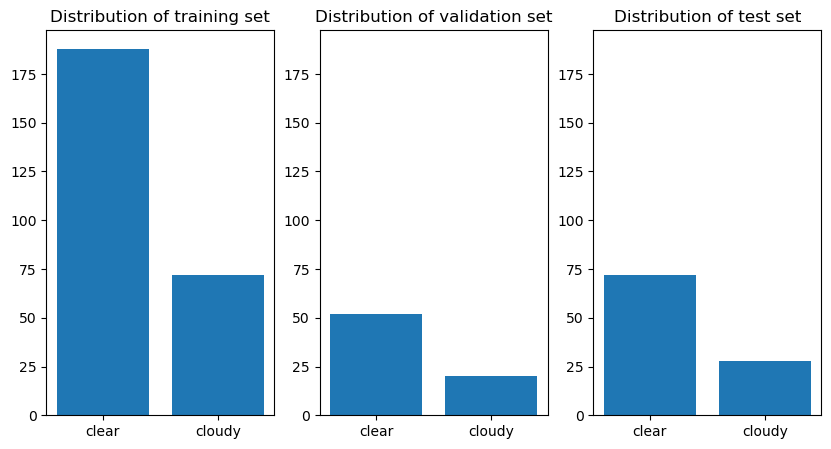

In [18]:
# plot distribution of each data set
labels = ["clear", "cloudy"]
labels_num = [0,1]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

# Bar for training
cloudy = np.count_nonzero(train_label)
clear = len(train_label) - cloudy
ax1.bar(labels_num, [clear,cloudy])
ax1.set_xticks(labels_num, labels)
ax1.set_title("Distribution of training set")
ylim = ax1.get_ylim()

# Bar for validation
cloudy = np.count_nonzero(val_label)
clear = len(val_label) - cloudy
ax2.bar(labels_num, [clear,cloudy])
ax2.set_xticks(labels_num, labels)
ax2.set_title("Distribution of validation set")
ax2.set_ylim(ylim)

# Bar for testing
cloudy = np.count_nonzero(test_label)
clear = len(test_label) - cloudy
ax3.bar(labels_num, [clear,cloudy])
ax3.set_xticks(labels_num, labels)
ax3.set_title("Distribution of test set")
ax3.set_ylim(ylim)


In [19]:
BATCH_SIZE = 10
SHUFFLE = False

# Train augmentations
transformation = v2.Compose([
    #v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ToTensor()
    # Add training augmentations here, remember: we do not want to transform the validation images.
    # For information about augmentation see: https://pytorch.org/vision/stable/transforms.html
])

train_data = utils.CustomImageDataset(os.path.join(utils.BASE_PATH_DATA, utils.LABEL_PATH_TRAIN), os.path.join(utils.BASE_PATH_DATA, utils.IMG_PATHS_TRAIN), transform=transformation)
labels = train_data.img_labels
class_sample_count = np.array(
    [len(np.where(labels == t)[0]) for t in np.unique(labels)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in labels])

samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, sampler=sampler)

val_data = utils.CustomImageDataset(os.path.join(utils.BASE_PATH_DATA, utils.LABEL_PATH_VAL), os.path.join(utils.BASE_PATH_DATA, utils.IMG_PATHS_VAL), transform=transforms.ToTensor())
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

test_data = utils.CustomImageDataset(os.path.join(utils.BASE_PATH_DATA, utils.LABEL_PATH_TEST), os.path.join(utils.BASE_PATH_DATA, utils.IMG_PATHS_TEST), transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [20]:
# showing the first batch when using tensors
def show_batch(dl): 
    for images,lables in dl: 
        rgb_img = images[:, [3,2,1], :, :]/torch.max(images[:, [3,2,1], :, :])
        list_img = [img for img in rgb_img]
        Grid = make_grid(list_img, nrow=5)
        img = transforms.ToPILImage()(Grid) 
        img.show() 
        break
        
# show first batch of train data
show_batch(train_loader)

Epoch 0, training loss: 0.0803674246256168, validation loss: 0.07557659182283613
Train accuracy = 0.5230769230769231
Validation accuracy = 0.6111111111111112
Epoch 1, training loss: 0.054492874443531035, validation loss: 0.05833327604664697
Train accuracy = 0.7461538461538462
Validation accuracy = 0.75
Epoch 2, training loss: 0.0504796153650834, validation loss: 0.04827209375798702
Train accuracy = 0.7423076923076923
Validation accuracy = 0.7916666666666666
Epoch 3, training loss: 0.054302863260874384, validation loss: 0.11534245643350813
Train accuracy = 0.7730769230769231
Validation accuracy = 0.4166666666666667
Epoch 4, training loss: 0.04366095891365638, validation loss: 0.04489297109345595
Train accuracy = 0.8076923076923077
Validation accuracy = 0.8194444444444444
Epoch 5, training loss: 0.04606324686453893, validation loss: 0.057929216573635735
Train accuracy = 0.7923076923076923
Validation accuracy = 0.75
Epoch 6, training loss: 0.053308906692724964, validation loss: 0.05090499

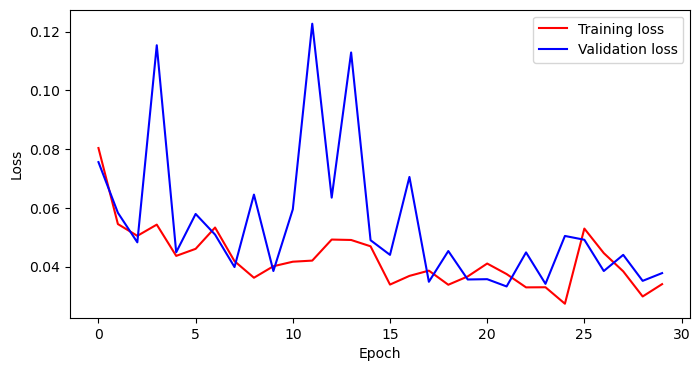

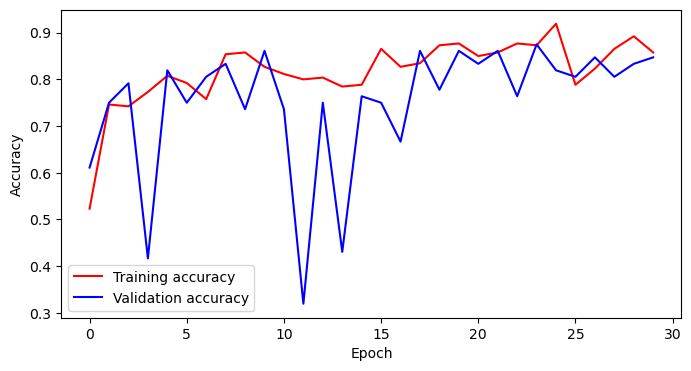

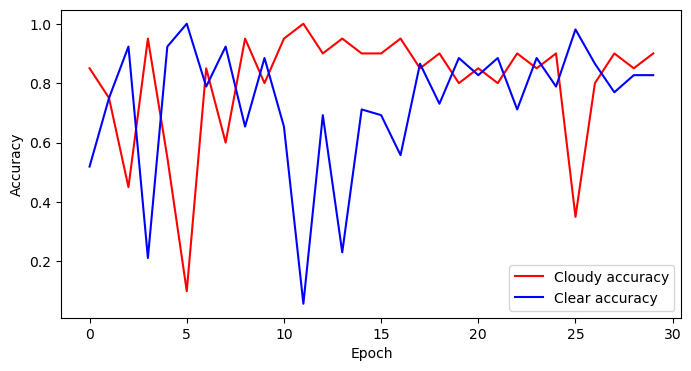

lowest loss for validation set: 0.033259914670553475, with an accuracy of 0.8611111111111112, cloud acc 0.8, clear acc = 0.8846153846153846


In [25]:
# Hyperparams
LEARNING_RATE = 0.01
EPOCHS = 30
network = nn.Sequential(
    nn.Linear(21*21*12, 64), 
    nn.ReLU(),
    nn.Linear(64, 64), 
    nn.ReLU(),
    nn.Linear(64, 64), 
    nn.ReLU(),
    nn.Linear(64, 1), 
    nn.Sigmoid()
)

# define loss
#loss_function = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.BCELoss()
# define optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(network.parameters(), lr=0.1)

utils.train_model(network, loss_function, optimizer, train_loader, val_loader, num_epochs = EPOCHS, sigmoid=True, cnn=False, show_log=True, show_plot=True)